___
**Areas of Interest**.  

4. See how goal similarity for an individual changes over time. Similarity meaning daily goals to weekly goals, and daily goals to prior daily goals.

5. Goal type vs targets: See which types of goals lead to better grades, affect, gaps, etc.
___

In [1]:
# !pip install sentence_transformers

In [23]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
import statsmodels.formula.api as smf
from patsy import dmatrix
from datetime import timedelta

In [24]:
self_report_path = "../data/proc/self_report.csv"
self_report_DF = pd.read_csv(self_report_path)
self_report_DF.head(3)

,ParticipantIdentifier,trial_date,DAILY_goal1_confidence,DAILY_goal1_consequences,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal2_confidence,DAILY_goal2_consequences,DAILY_goal2_effort,DAILY_goal2_importance,DAILY_goal1_set,DAILY_goal2_set,DAILY_goal1_report,DAILY_goal2_report,DAILY_goal2_interaction_eachOther,DAILY_goal1_motivationExternal,DAILY_goal1_motivationInternal,DAILY_goal2_motivationExternal,DAILY_goal2_motivationInternal
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,4.0,3.0,6.0,5.0,6.0,1.0,7.0,4.0,"Study history and psychology, practice the vio...",Do exercise,NaN,NaN,NaN,7.0,6.0,3.0,7.0
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,5.0,4.0,7.0,7.0,3.0,3.0,5.0,5.0,study history lectures,Watch the historical movie,70.0,100.0,NaN,6.0,7.0,6.0,5.0
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,7.0,5.0,4.0,7.0,2.0,7.0,7.0,7.0,Watch a historical movie,Review for psy and bio,89.0,0.0,NaN,7.0,5.0,7.0,6.0


In [25]:
embeddings = pd.read_csv("../data/proc/embeddings/daily_embeddings_wide.csv")
columns = [
    'ParticipantIdentifier',
    'trial_date',
    'DAILY_goal1_effort',
    'DAILY_goal2_effort',
    'DAILY_goal1_importance',
    'DAILY_goal2_importance',
    'goal1_completion',
    'goal2_completion',
    'day_diff',
    'openai_emb_goal1',
    'openai_emb_goal2',
    'mini_lm_emb_goal1',
    'mini_lm_emb_goal2'
]

embeddings = embeddings[columns]
embeddings.head()

,ParticipantIdentifier,trial_date,DAILY_goal1_effort,DAILY_goal2_effort,DAILY_goal1_importance,DAILY_goal2_importance,goal1_completion,goal2_completion,day_diff,openai_emb_goal1,openai_emb_goal2,mini_lm_emb_goal1,mini_lm_emb_goal2
0,0151d9f1-1644-4437-805e-02f5e244a690,2023-01-31,5.0,5.0,6.0,7.0,90.0,15.0,1.0,"[-0.028347458690404892, 0.004471572581678629, ...","[0.014535731635987759, -0.013706667348742485, ...","tensor([ 6.2898e-02, 8.4798e-02, -3.1478e-02,...","tensor([-1.5529e-02, 9.8117e-02, 1.2250e-02,..."
1,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-01,5.0,3.0,6.0,5.0,71.0,100.0,1.0,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.04658700153231621, 0.0008135903044603765, ...","tensor([-6.1230e-02, 4.1099e-02, 3.9465e-02,...","tensor([-1.7502e-02, 3.1926e-04, -4.1914e-02,..."
2,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-02,6.0,4.0,7.0,3.0,100.0,77.0,1.0,"[-0.002160745905712247, 0.0015396077651530504,...","[-0.014762434177100658, 0.02009924314916134, -...","tensor([-6.1230e-02, 4.1099e-02, 3.9465e-02,...","tensor([-2.1032e-02, 1.1304e-02, -1.0018e-01,..."
3,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-03,5.0,6.0,5.0,5.0,100.0,100.0,1.0,"[-0.03221265226602554, -0.010712618008255959, ...","[0.007794945500791073, 0.014498291537165642, -...","tensor([-1.4714e-02, 2.7700e-03, 5.9970e-02,...","tensor([-4.5210e-02, -8.7845e-03, -5.2368e-02,..."
4,0151d9f1-1644-4437-805e-02f5e244a690,2023-02-04,5.0,6.0,5.0,6.0,90.0,54.0,1.0,"[-0.0068207005970180035, 0.024796752259135246,...","[-0.012282999232411385, 0.016515225172042847, ...","tensor([ 1.4817e-02, -8.4915e-03, -2.0395e-02,...","tensor([ 2.7951e-02, 7.6552e-02, -2.3213e-02,..."


In [26]:
emb_c = [    
    'ParticipantIdentifier',
    'trial_date',
    'openai_emb_goal1',
    'openai_emb_goal2',
    'mini_lm_emb_goal1',
    'mini_lm_emb_goal2'
    ]

df = self_report_DF.merge(embeddings[emb_c], on=['ParticipantIdentifier', 'trial_date'], how='inner')
df.head()

,ParticipantIdentifier,trial_date,DAILY_goal1_confidence,DAILY_goal1_consequences,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal2_confidence,DAILY_goal2_consequences,DAILY_goal2_effort,DAILY_goal2_importance,...,DAILY_goal2_report,DAILY_goal2_interaction_eachOther,DAILY_goal1_motivationExternal,DAILY_goal1_motivationInternal,DAILY_goal2_motivationExternal,DAILY_goal2_motivationInternal,openai_emb_goal1,openai_emb_goal2,mini_lm_emb_goal1,mini_lm_emb_goal2
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,5.0,4.0,7.0,7.0,3.0,3.0,5.0,5.0,...,100.0,NaN,6.0,7.0,6.0,5.0,"[0.012393222190439701, -0.002821733709424734, ...","[0.022916121408343315, 0.023403340950608253, 0...","tensor([ 2.9382e-02, 2.0510e-02, 2.2261e-03,...","tensor([ 2.7087e-02, 2.3227e-02, 2.1925e-02,..."
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,7.0,5.0,4.0,7.0,2.0,7.0,7.0,7.0,...,0.0,NaN,7.0,5.0,7.0,6.0,"[0.0045208376832306385, 0.03374333307147026, -...","[-0.008139832876622677, 0.020708998665213585, ...","tensor([-4.0347e-02, 1.4071e-02, -3.7773e-02,...","tensor([-6.5769e-02, 3.5823e-02, -7.4685e-02,..."
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,5.0,7.0,7.0,7.0,7.0,3.0,7.0,5.0,...,0.0,NaN,7.0,4.0,7.0,5.0,"[-0.009907735511660576, 0.02444012649357319, -...","[-0.005031808279454708, 0.012548963539302349, ...","tensor([-5.7473e-02, 8.7917e-03, -8.3087e-02,...","tensor([-8.0590e-02, -3.2317e-02, -1.2427e-01,..."
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,5.0,7.0,7.0,7.0,7.0,7.0,2.0,7.0,...,100.0,NaN,7.0,7.0,7.0,3.0,"[-0.026907388120889664, 0.02973778545856476, -...","[-0.006640985142439604, 0.02700134553015232, -...","tensor([-1.1085e-01, 6.5687e-02, -1.0548e-01,...","tensor([-9.8379e-02, 7.8795e-03, -1.0233e-01,..."
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-05,6.0,7.0,5.0,7.0,4.0,5.0,5.0,7.0,...,100.0,NaN,7.0,7.0,7.0,7.0,"[-0.026907388120889664, 0.02973778545856476, -...","[0.020862402394413948, 0.013716430403292179, -...","tensor([-1.1085e-01, 6.5687e-02, -1.0548e-01,...","tensor([ 9.1611e-02, -1.1984e-02, -5.3260e-02,..."


In [27]:
len(df)

7593

___
PREPROCESS
1. Keep only participants with >40 entries
3. Keep only relevant columns + rename. 
___

In [28]:
df = df[
    (df['DAILY_goal1_set'].str.split().str.len() >= 1) |
    (df['DAILY_goal2_set'].str.split().str.len() >= 1)
].copy()

In [29]:
counts = df['ParticipantIdentifier'].value_counts()
participants_gt30 = counts[counts > 40].reset_index()['ParticipantIdentifier'].to_list()

In [30]:
len(participants_gt30)

108

In [31]:
cols = [
    'ParticipantIdentifier', 
    'trial_date',	
    'DAILY_goal1_effort',
    'DAILY_goal1_importance',
    'DAILY_goal2_effort',
    'DAILY_goal2_importance',
    'DAILY_goal1_set',
    'DAILY_goal2_set',	
    'DAILY_goal1_report',
    'DAILY_goal2_report',
    'DAILY_goal1_effort',
    'DAILY_goal2_effort',
    'openai_emb_goal1',
    'openai_emb_goal2',
]

In [32]:
proc = df[df['ParticipantIdentifier'].isin(participants_gt30)][cols].dropna()

In [33]:
# Ensure date column is datetime
proc['trial_date'] = pd.to_datetime(proc['trial_date'])

# Calculate difference in days from previous entry
proc['day_diff'] = proc.groupby('ParticipantIdentifier')['trial_date'].diff().dt.days

df = proc.dropna()

In [34]:
df.head(3)

,ParticipantIdentifier,trial_date,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal2_effort,DAILY_goal2_importance,DAILY_goal1_set,DAILY_goal2_set,DAILY_goal1_report,DAILY_goal2_report,DAILY_goal1_effort,DAILY_goal2_effort,openai_emb_goal1,openai_emb_goal2,day_diff
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,4.0,7.0,7.0,7.0,Watch a historical movie,Review for psy and bio,89.0,0.0,4.0,7.0,"[0.0045208376832306385, 0.03374333307147026, -...","[-0.008139832876622677, 0.020708998665213585, ...",1.0
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,7.0,7.0,7.0,5.0,review,movie review,30.0,0.0,7.0,7.0,"[-0.009907735511660576, 0.02444012649357319, -...","[-0.005031808279454708, 0.012548963539302349, ...",1.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,7.0,7.0,2.0,7.0,review,concept map,53.0,100.0,7.0,2.0,"[-0.026907388120889664, 0.02973778545856476, -...","[-0.006640985142439604, 0.02700134553015232, -...",1.0


In [35]:
len(df)

7313

___
PREPROCESS:  
4. GAP ANALYSIS
___

In [36]:
gap_stats = (
    df.groupby("ParticipantIdentifier")["day_diff"]
      .agg(["mean", "var", "max", "count"])
      .reset_index()
)

In [ ]:
# filtered_ids = gap_stats.loc[
#     (gap_stats["mean"] <= 2) & (gap_stats["var"] <= 2),
#     "ParticipantIdentifier"
# ]

# df_filtered = df[df["ParticipantIdentifier"].isin(filtered_ids)]

In [37]:
df_filtered = df.rename(columns={
    'DAILY_goal1_report': 'goal1_completion',
    'DAILY_goal2_report': 'goal2_completion'
})

In [38]:
df_filtered.head()

,ParticipantIdentifier,trial_date,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal2_effort,DAILY_goal2_importance,DAILY_goal1_set,DAILY_goal2_set,goal1_completion,goal2_completion,DAILY_goal1_effort,DAILY_goal2_effort,openai_emb_goal1,openai_emb_goal2,day_diff
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,4.0,7.0,7.0,7.0,Watch a historical movie,Review for psy and bio,89.0,0.0,4.0,7.0,"[0.0045208376832306385, 0.03374333307147026, -...","[-0.008139832876622677, 0.020708998665213585, ...",1.0
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,7.0,7.0,7.0,5.0,review,movie review,30.0,0.0,7.0,7.0,"[-0.009907735511660576, 0.02444012649357319, -...","[-0.005031808279454708, 0.012548963539302349, ...",1.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,7.0,7.0,2.0,7.0,review,concept map,53.0,100.0,7.0,2.0,"[-0.026907388120889664, 0.02973778545856476, -...","[-0.006640985142439604, 0.02700134553015232, -...",1.0
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-05,5.0,7.0,5.0,7.0,review bio,review psy,70.0,100.0,5.0,5.0,"[-0.026907388120889664, 0.02973778545856476, -...","[0.020862402394413948, 0.013716430403292179, -...",1.0
5,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-06,4.0,5.0,4.0,7.0,practice the violin,wrap up study,100.0,100.0,4.0,4.0,"[-0.00018124986672773957, 0.030945606529712677...","[-0.041391149163246155, 0.026516731828451157, ...",1.0


In [39]:
len(df_filtered['ParticipantIdentifier'])

7313

In [40]:
df = df_filtered

In [41]:
goal_cols = [
    "ParticipantIdentifier", 
    "trial_date",
    "DAILY_goal1_set",
    "DAILY_goal2_set",
]

other_cols = [
    "ParticipantIdentifier", 
    "trial_date",
    "DAILY_goal1_effort",
    "DAILY_goal1_importance",
    "DAILY_goal2_effort",
    "DAILY_goal2_importance",
    "goal1_completion",
    "goal2_completion",
    "DAILY_goal1_effort",
    "DAILY_goal2_effort",
    "day_diff"
]

goal_temp = df[goal_cols].copy()
otherDF = df[other_cols].copy()


In [42]:
goal_temp["trial_date"] = pd.to_datetime(goal_temp["trial_date"]) + timedelta(days=1)
otherDF["trial_date"] = pd.to_datetime(otherDF["trial_date"])
mergedDF = pd.merge(
    goal_temp, 
    otherDF, 
    on=["ParticipantIdentifier", "trial_date"], 
    how="inner"
)

mergedDF.head()

,ParticipantIdentifier,trial_date,DAILY_goal1_set,DAILY_goal2_set,DAILY_goal1_effort,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal2_effort,DAILY_goal2_effort,DAILY_goal2_importance,goal1_completion,goal2_completion,DAILY_goal1_effort,DAILY_goal1_effort,DAILY_goal2_effort,DAILY_goal2_effort,day_diff
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,Watch a historical movie,Review for psy and bio,7.0,7.0,7.0,7.0,7.0,5.0,30.0,0.0,7.0,7.0,7.0,7.0,1.0
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,review,movie review,7.0,7.0,7.0,2.0,2.0,7.0,53.0,100.0,7.0,7.0,2.0,2.0,1.0
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-05,review,concept map,5.0,5.0,7.0,5.0,5.0,7.0,70.0,100.0,5.0,5.0,5.0,5.0,1.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-06,review bio,review psy,4.0,4.0,5.0,4.0,4.0,7.0,100.0,100.0,4.0,4.0,4.0,4.0,1.0
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-07,practice the violin,wrap up study,5.0,5.0,4.0,5.0,5.0,7.0,100.0,30.0,5.0,5.0,5.0,5.0,1.0


In [43]:
len(mergedDF)

6959

In [44]:
df = mergedDF

___

In [284]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [285]:
plot_df = testDF.dropna(subset=["prev_goal_completion", "goal_sim", "ParticipantIdentifier"])

KeyError: ['prev_goal_completion']

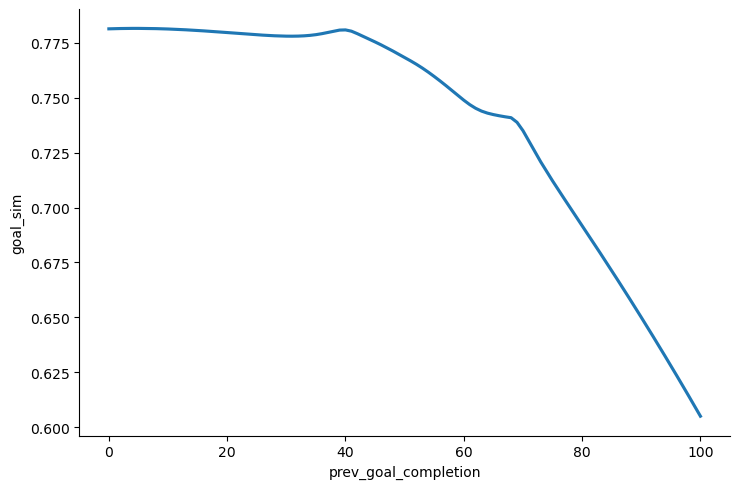

In [ ]:
sns.lmplot(data=plot_df, 
           x="prev_goal_completion", 
           y="goal_sim", 
           lowess=True, scatter=False, aspect=1.5)

/Users/farhan/miniforge3/envs/wildfire/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


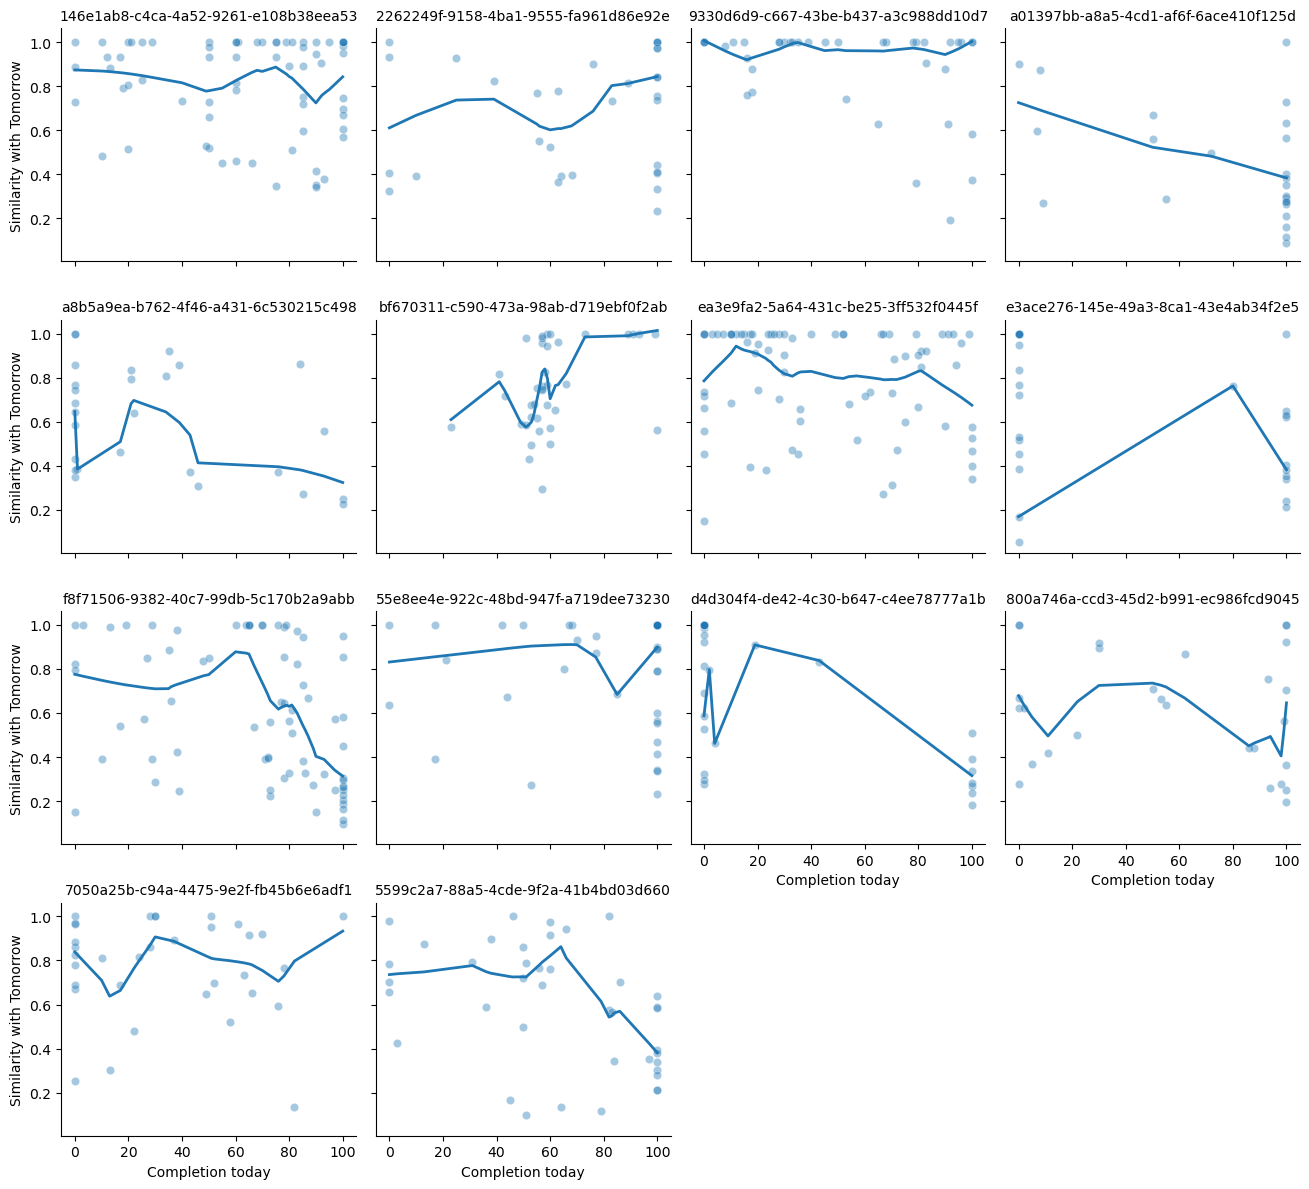

In [ ]:
g = sns.FacetGrid(plot_df, col="ParticipantIdentifier", col_wrap=4, height=3, aspect=1.1)
g.map_dataframe(sns.scatterplot, x="prev_goal_completion", y="goal_sim", alpha=0.4)

# Add LOWESS with custom frac
frac = 0.4  # adjust like span
def add_lowess(data, color, **kwargs):
    smoothed = lowess(data["goal_sim"], data["prev_goal_completion"], frac=frac)
    plt.plot(smoothed[:,0], smoothed[:,1], color=color, linewidth=2)

g.map_dataframe(add_lowess)

g.set_axis_labels("Completion today", "Similarity with Tomorrow")
g.set_titles("{col_name}")
plt.show()

*Interaction ✅*
This is momentum, not coasting.
___

___
Need to see how completion on a certain day affects similarity of goals with the next day
___


ggplot(subset(ibfAll, Filter28),
       aes(taskHrsFrom5AM,dailyCogPrecision)) + 
  stat_smooth(method="loess", formula=y~x, span = 1.2,
    alpha=0.2, linewidth=2, color = 'slateblue4') + theme_minimal() + 
  xlab('Task Completion Time') + ylab('Daily Cognitive Precision')

Larger span ‎ = 1.2much smoother
Smaller span ‎ = 1.2much mortgaged but allows us to see more detail

How completion today affects similarity of the most similar goal tmrw



I should take completion of the most similar goals
The most similar goal tomorrow is a natural anchor:
It ensures you’re looking at the closest conceptual continuation of today’s goal.
If completion affects how “goal trajectories” evolve, it should be most evident in the nearest neighbor goal across days.
Without this matching, you’d be averaging across irrelevant pairs (e.g., comparing today’s “Finish essay” with tomorrow’s “Go jogging”).
Why not use all goals tomorrow?
You could — but then you’d mix signal with noise.
Imagine today you had a school goal, and tomorrow you have 2 work goals and 1 school goal.
Only the school goal is “in the same space.”
The work goals would artificially deflate similarity measures, drowning out the effect.
By using the most similar match, you’re controlling for topic/domain drift.

In [288]:
labelled_daily_goals_long_path = "./results/labelled_daily_goals_long.csv"

affect_path = "./results/affectDF_wide.csv"

gap_path = "./results/gapDF.csv"

In [ ]:
cols = [
    "ParticipantIdentifier",
    "trial_date",
    "ResponseIdentifier",
    "Answers",
    "label"
]

lab_daily_goals_DF = pd.read_csv(labelled_daily_goals_long_path)[cols]

lab_daily_goals_DF.head(3)

,ParticipantIdentifier,trial_date,ResponseIdentifier,Answers,label
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,DAILY_goal1_set,"Study history and psychology, practice the violin",Learning
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,DAILY_goal1_set,study history lectures,School
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,DAILY_goal1_set,Watch a historical movie,Culture


In [ ]:
affectCols = [
    "ParticipantIdentifier",
    "trial_date",
    "mean_pos_evening",
    "mean_neg_evening",
    "mean_affect_diff"
]

affectDF = pd.read_csv(affect_path)[affectCols]

affectDF.head(3)

,ParticipantIdentifier,trial_date,mean_pos_evening,mean_neg_evening,mean_affect_diff
0,d5f19109-8219-40e6-9fc1-6e02c3a06dcd,2023-01-30,2.375,1.833333,0.541667
1,d5f19109-8219-40e6-9fc1-6e02c3a06dcd,2023-01-31,1.250,1.666667,-0.416667
2,d5f19109-8219-40e6-9fc1-6e02c3a06dcd,2023-02-01,1.375,2.250000,-0.875000


___
Affect x Goal Type
___

In [ ]:
affect_goal_type = lab_daily_goals_DF.merge(
    affectDF,
    on=["ParticipantIdentifier", "trial_date"],
    how="left")

affect_goal_type.head()

,ParticipantIdentifier,trial_date,ResponseIdentifier,Answers,label,mean_pos_evening,mean_neg_evening,mean_affect_diff
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,DAILY_goal1_set,"Study history and psychology, practice the violin",Learning,2.750,2.833333,-0.083333
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,DAILY_goal1_set,study history lectures,School,2.625,1.833333,0.791667
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,DAILY_goal1_set,Watch a historical movie,Culture,1.875,3.250000,-1.375000
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,DAILY_goal1_set,review,School,1.500,2.833333,-1.333333
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,DAILY_goal1_set,review,School,1.375,2.833333,-1.458333


In [ ]:
affect_goal_type["label"].value_counts()

label
School                   11087
Other                     4330
Exercise                  1232
Work                      1071
MentalPersonal_Health      890
Sleep                      795
Diet                       711
Housework                  594
Hobby                      313
Time_Management            297
Learning                   284
Reading_leisure            270
Medical_Health             264
Social_life                260
Admin                      238
Self-Improvement           231
Friends                    208
Future_Planning            169
Family                     169
Punctuality                138
Cooking                    122
Online                      82
Personal_Values             74
TV_Streaming                56
Finances                    56
Community involvement       51
Volunteering                39
Sports_playing              35
Video games                 35
Phone                       35
Partner                     27
SocialMedia                 17
Cu

In [ ]:
categories = [
    "School",
    "Other",
    "Exercise",
    "Work",
    "MentalPersonal_Health",
    "Sleep",
    "Diet",
    "Housework",
    "Hobby",
    "Time_Management",
    "Learning",
    "Reading_leisure",
    "Medical_Health",
    "Social_life",
    "Admin",
    "Self-Improvement",
    "Friends",
    "Future_Planning",
    "Family",
    "Punctuality",
    "Cooking"
]

# affect_df_by_freq = affect_goal_type.loc[affect_goal_type['label'].isin(categories)]
affect_df_by_freq = affect_goal_type

affect_df_by_freq

,ParticipantIdentifier,trial_date,ResponseIdentifier,Answers,label,mean_pos_evening,mean_neg_evening,mean_affect_diff
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,DAILY_goal1_set,"Study history and psychology, practice the violin",Learning,2.750,2.833333,-0.083333
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,DAILY_goal1_set,study history lectures,School,2.625,1.833333,0.791667
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,DAILY_goal1_set,Watch a historical movie,Culture,1.875,3.250000,-1.375000
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,DAILY_goal1_set,review,School,1.500,2.833333,-1.333333
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,DAILY_goal1_set,review,School,1.375,2.833333,-1.458333
...,...,...,...,...,...,...,...,...
24620,b62d508b-4768-4dc4-9bf3-bc8f59bf2388,2023-03-28,DAILY_goal2_set,Work on problem set 6,School,2.875,1.583333,1.291667
24621,b62d508b-4768-4dc4-9bf3-bc8f59bf2388,2023-03-29,DAILY_goal2_set,Prepare for exam,School,2.625,1.583333,1.041667
24622,b62d508b-4768-4dc4-9bf3-bc8f59bf2388,2023-03-30,DAILY_goal2_set,Write exam,School,3.750,1.333333,2.416667
24623,b62d508b-4768-4dc4-9bf3-bc8f59bf2388,2023-03-31,DAILY_goal2_set,Plic paper,School,2.750,2.333333,0.416667


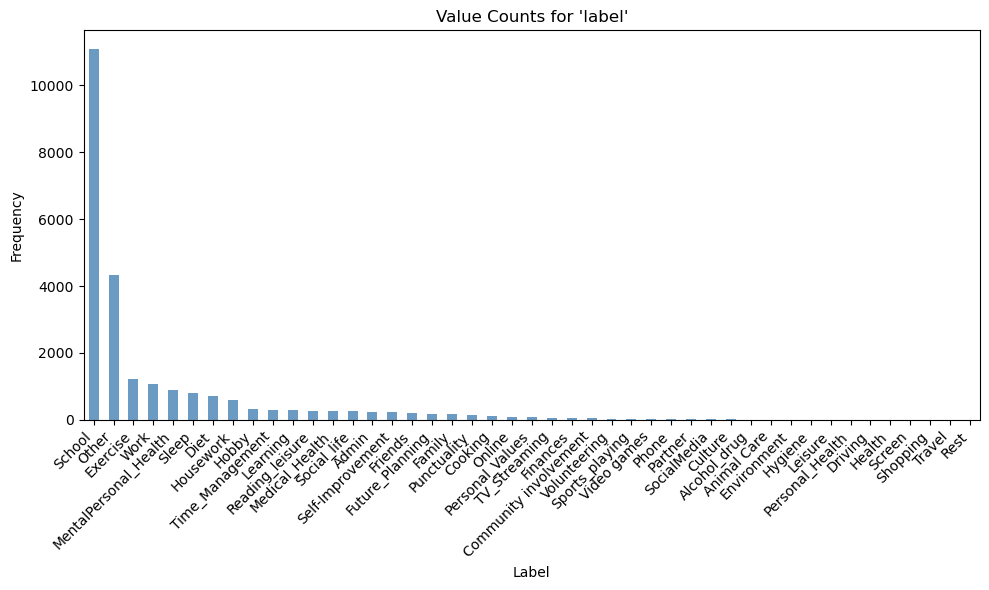

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: column name is 'label'
value_counts = lab_daily_goals_DF["label"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
value_counts.plot(kind="bar", color="steelblue", alpha=0.8)
plt.title("Value Counts for 'label'")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

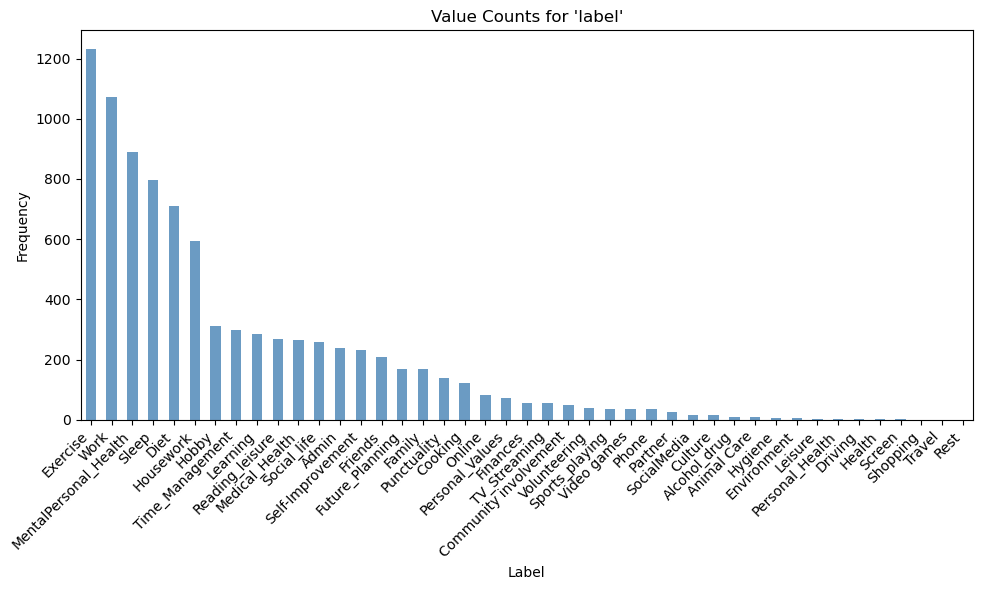

In [ ]:
sdf = lab_daily_goals_DF.loc[lab_daily_goals_DF["label"] != "School"]
sdf = sdf.loc[sdf["label"] != "Other"]

# Example: column name is 'label'
value_counts = sdf["label"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
value_counts.plot(kind="bar", color="steelblue", alpha=0.8)
plt.title("Value Counts for 'label'")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
affect_df_by_freq = affect_df_by_freq[[
    "ParticipantIdentifier",
    "trial_date",
    "label",
    "mean_pos_evening",
    "mean_neg_evening"
]]

affect_df_by_freq.head()

,ParticipantIdentifier,trial_date,label,mean_pos_evening,mean_neg_evening
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,Learning,2.750,2.833333
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,School,2.625,1.833333
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,Culture,1.875,3.250000
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,School,1.500,2.833333
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,School,1.375,2.833333


In [ ]:
categories = [
    "School",
    "Other",
    "Exercise",
    "Work",
    "MentalPersonal_Health",
    "Sleep",
    "Diet",
    "Housework",
    "Hobby",
    "Time_Management",
    "Learning",
    "Reading_leisure",
    "Medical_Health",
    "Social_life",
    "Admin",
    "Self-Improvement",
    "Friends",
    "Future_Planning",
    "Family",
    "Punctuality",
    "Cooking"
]

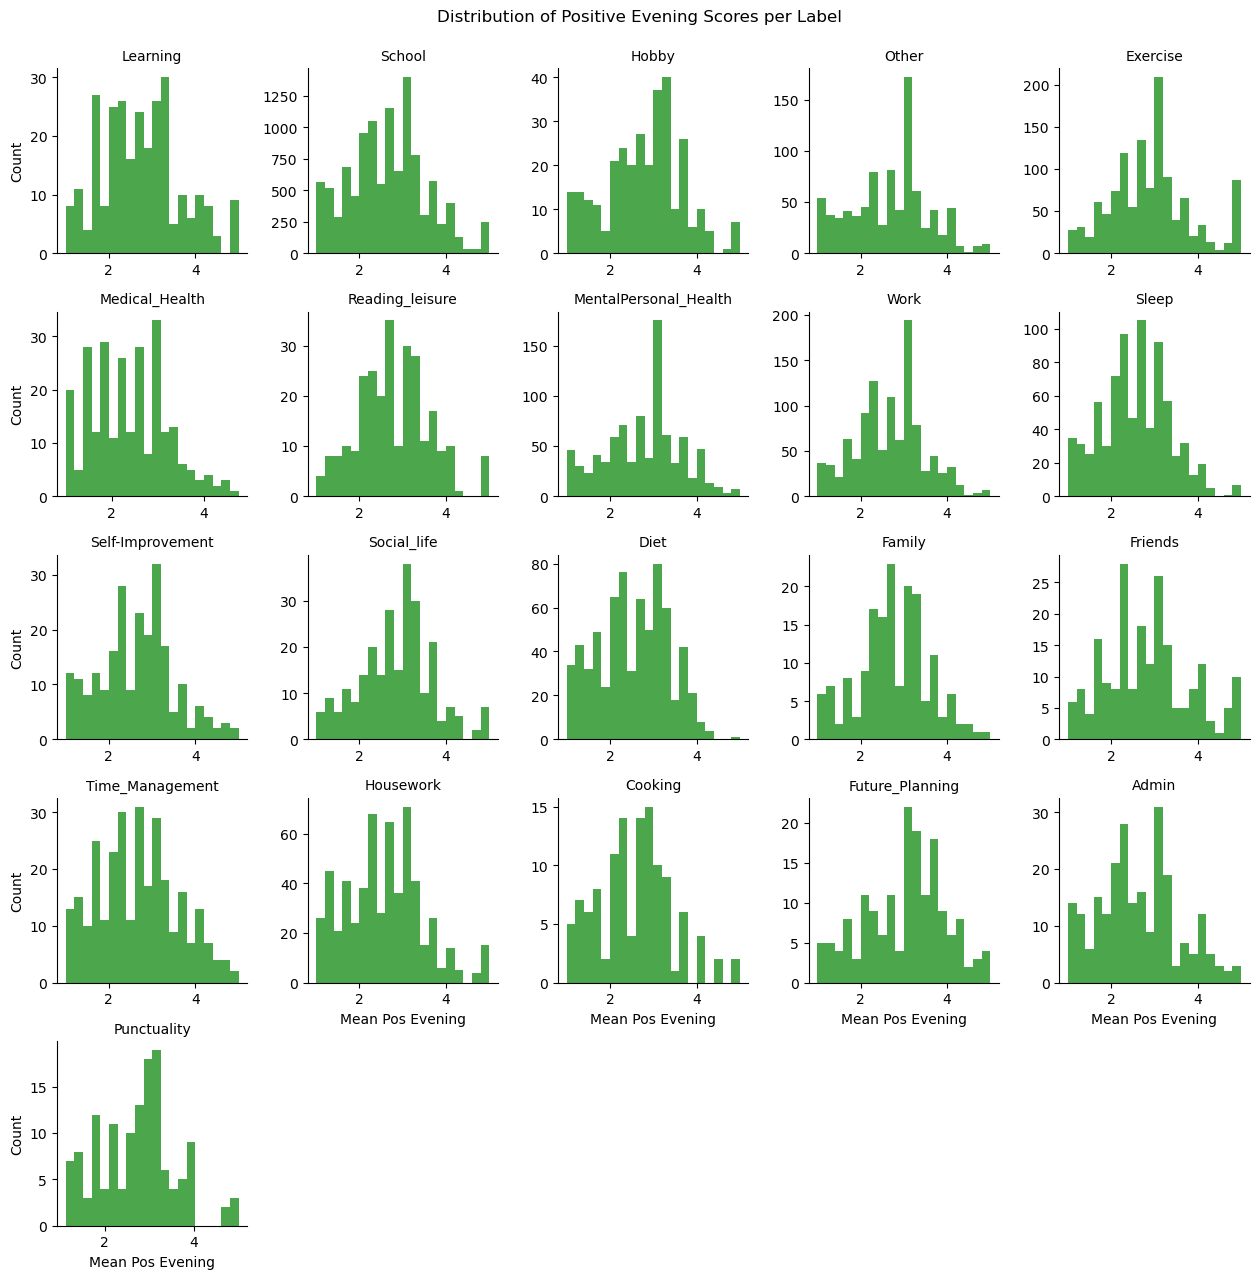

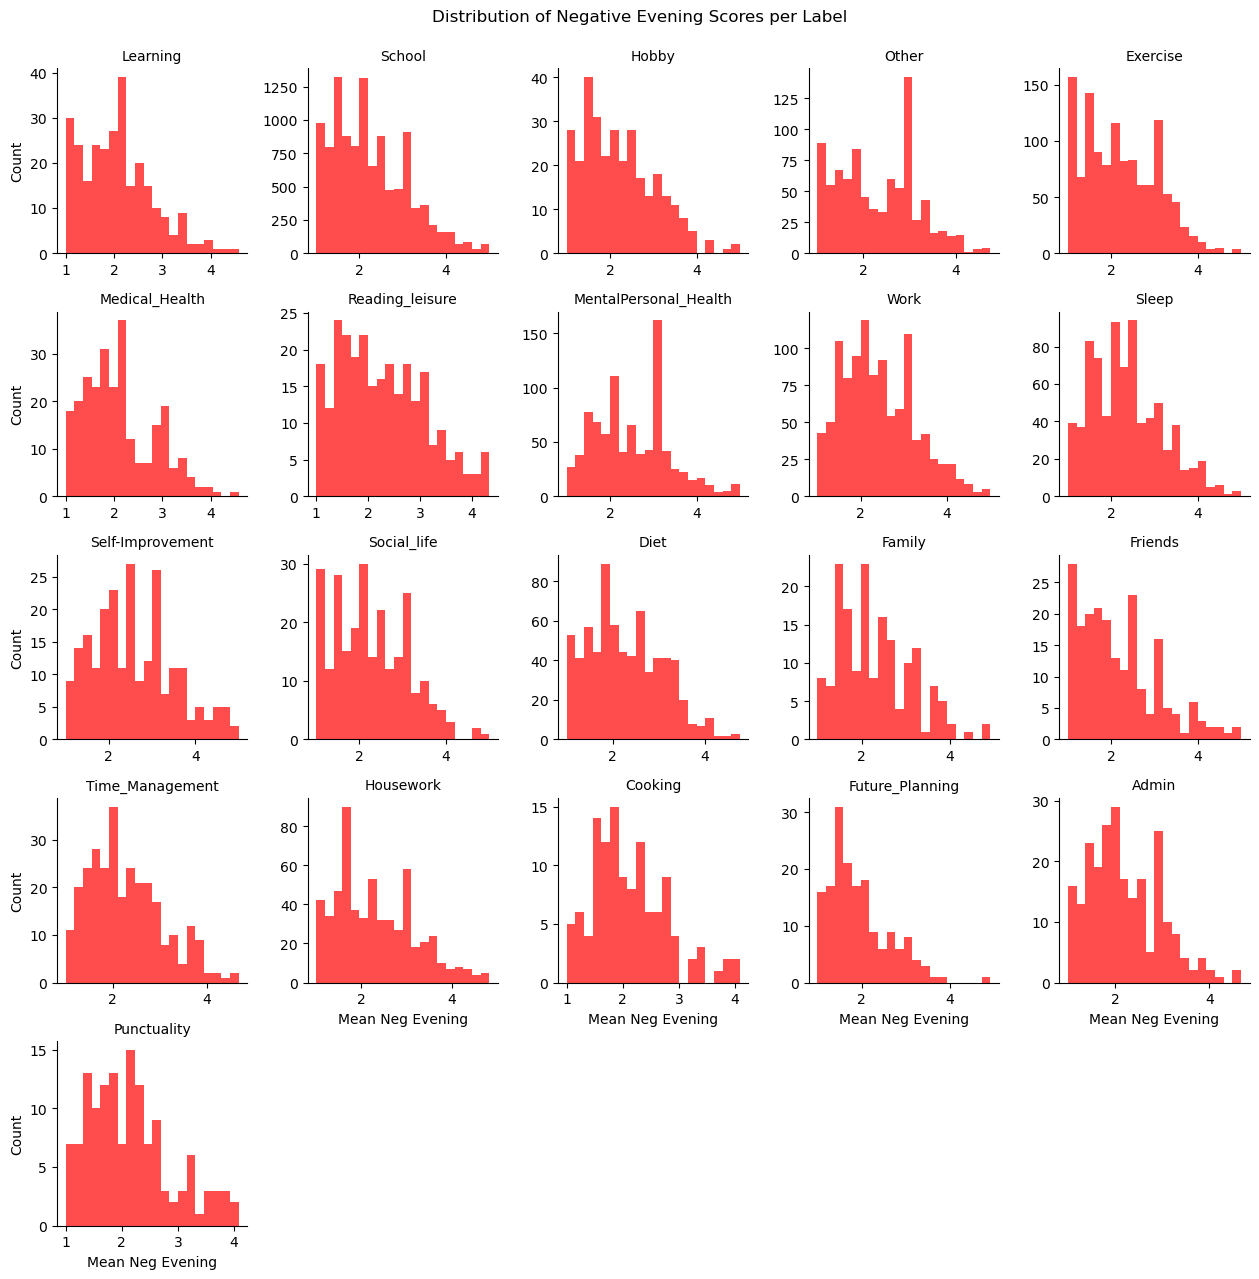

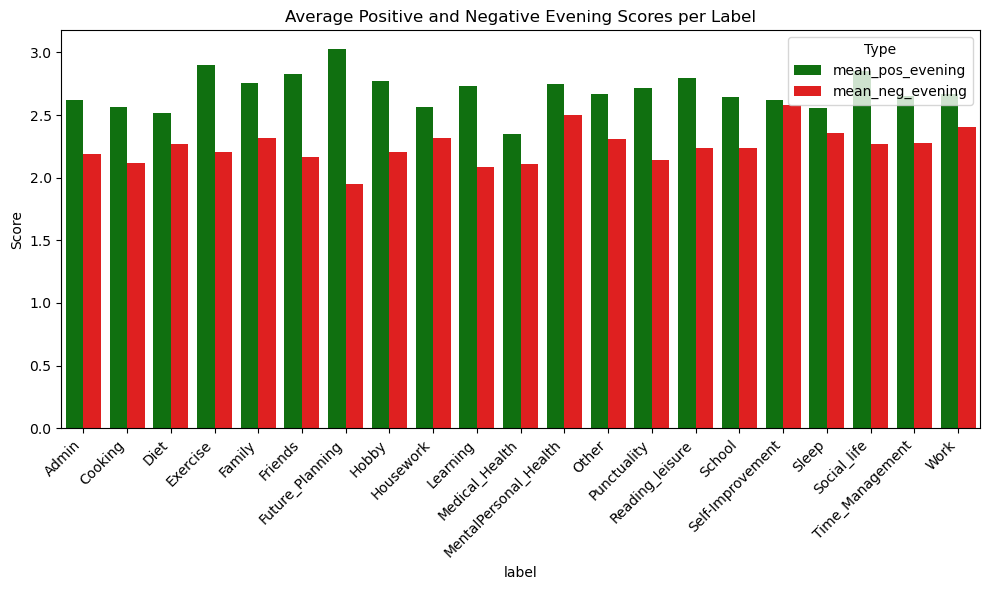

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume df has columns: ["label", "mean_pos_evening", "mean_neg_evening"]

df = affect_df_by_freq.loc[affect_df_by_freq["label"].isin(categories)]

# --- 1. Grid of histograms for POS ---
g_pos = sns.FacetGrid(df, col="label", col_wrap=5, sharex=False, sharey=False, height=2.5)
g_pos.map(plt.hist, "mean_pos_evening", bins=20, color="green", alpha=0.7)
g_pos.set_titles("{col_name}")
g_pos.set_axis_labels("Mean Pos Evening", "Count")
g_pos.fig.suptitle("Distribution of Positive Evening Scores per Label", y=1.02)

# --- 2. Grid of histograms for NEG ---
g_neg = sns.FacetGrid(df, col="label", col_wrap=5, sharex=False, sharey=False, height=2.5)
g_neg.map(plt.hist, "mean_neg_evening", bins=20, color="red", alpha=0.7)
g_neg.set_titles("{col_name}")
g_neg.set_axis_labels("Mean Neg Evening", "Count")
g_neg.fig.suptitle("Distribution of Negative Evening Scores per Label", y=1.02)

# --- 3. Bar chart of average pos vs neg per label ---
avg_scores = df.groupby("label")[["mean_pos_evening", "mean_neg_evening"]].mean().reset_index()
avg_scores = avg_scores.melt(id_vars="label", var_name="Type", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=avg_scores, x="label", y="Score", hue="Type",
            palette={"mean_pos_evening": "green", "mean_neg_evening": "red"})
plt.xticks(rotation=45, ha="right")
plt.title("Average Positive and Negative Evening Scores per Label")
plt.tight_layout()
plt.show()


___
___

In [ ]:
gapDF = pd.read_csv("./results/gapDF.csv")
gapDF.head()

,ParticipantIdentifier,trial_date,DAILY_past24_gap,weighted_gap,reported_gap
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,37.0,31.500,15.0
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,80.0,73.875,55.5
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,80.0,81.250,85.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,30.0,28.375,23.5
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,43.0,36.000,15.0


In [ ]:
gap_goal_type = lab_daily_goals_DF.merge(
    gapDF,
    on=["ParticipantIdentifier", "trial_date"],
    how="left").dropna()

gap_goal_type.head()

,ParticipantIdentifier,trial_date,ResponseIdentifier,Answers,label,DAILY_past24_gap,weighted_gap,reported_gap
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,DAILY_goal1_set,"Study history and psychology, practice the violin",Learning,37.0,31.500,15.0
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,DAILY_goal1_set,study history lectures,School,80.0,73.875,55.5
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,DAILY_goal1_set,Watch a historical movie,Culture,80.0,81.250,85.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,DAILY_goal1_set,review,School,30.0,28.375,23.5
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,DAILY_goal1_set,review,School,43.0,36.000,15.0


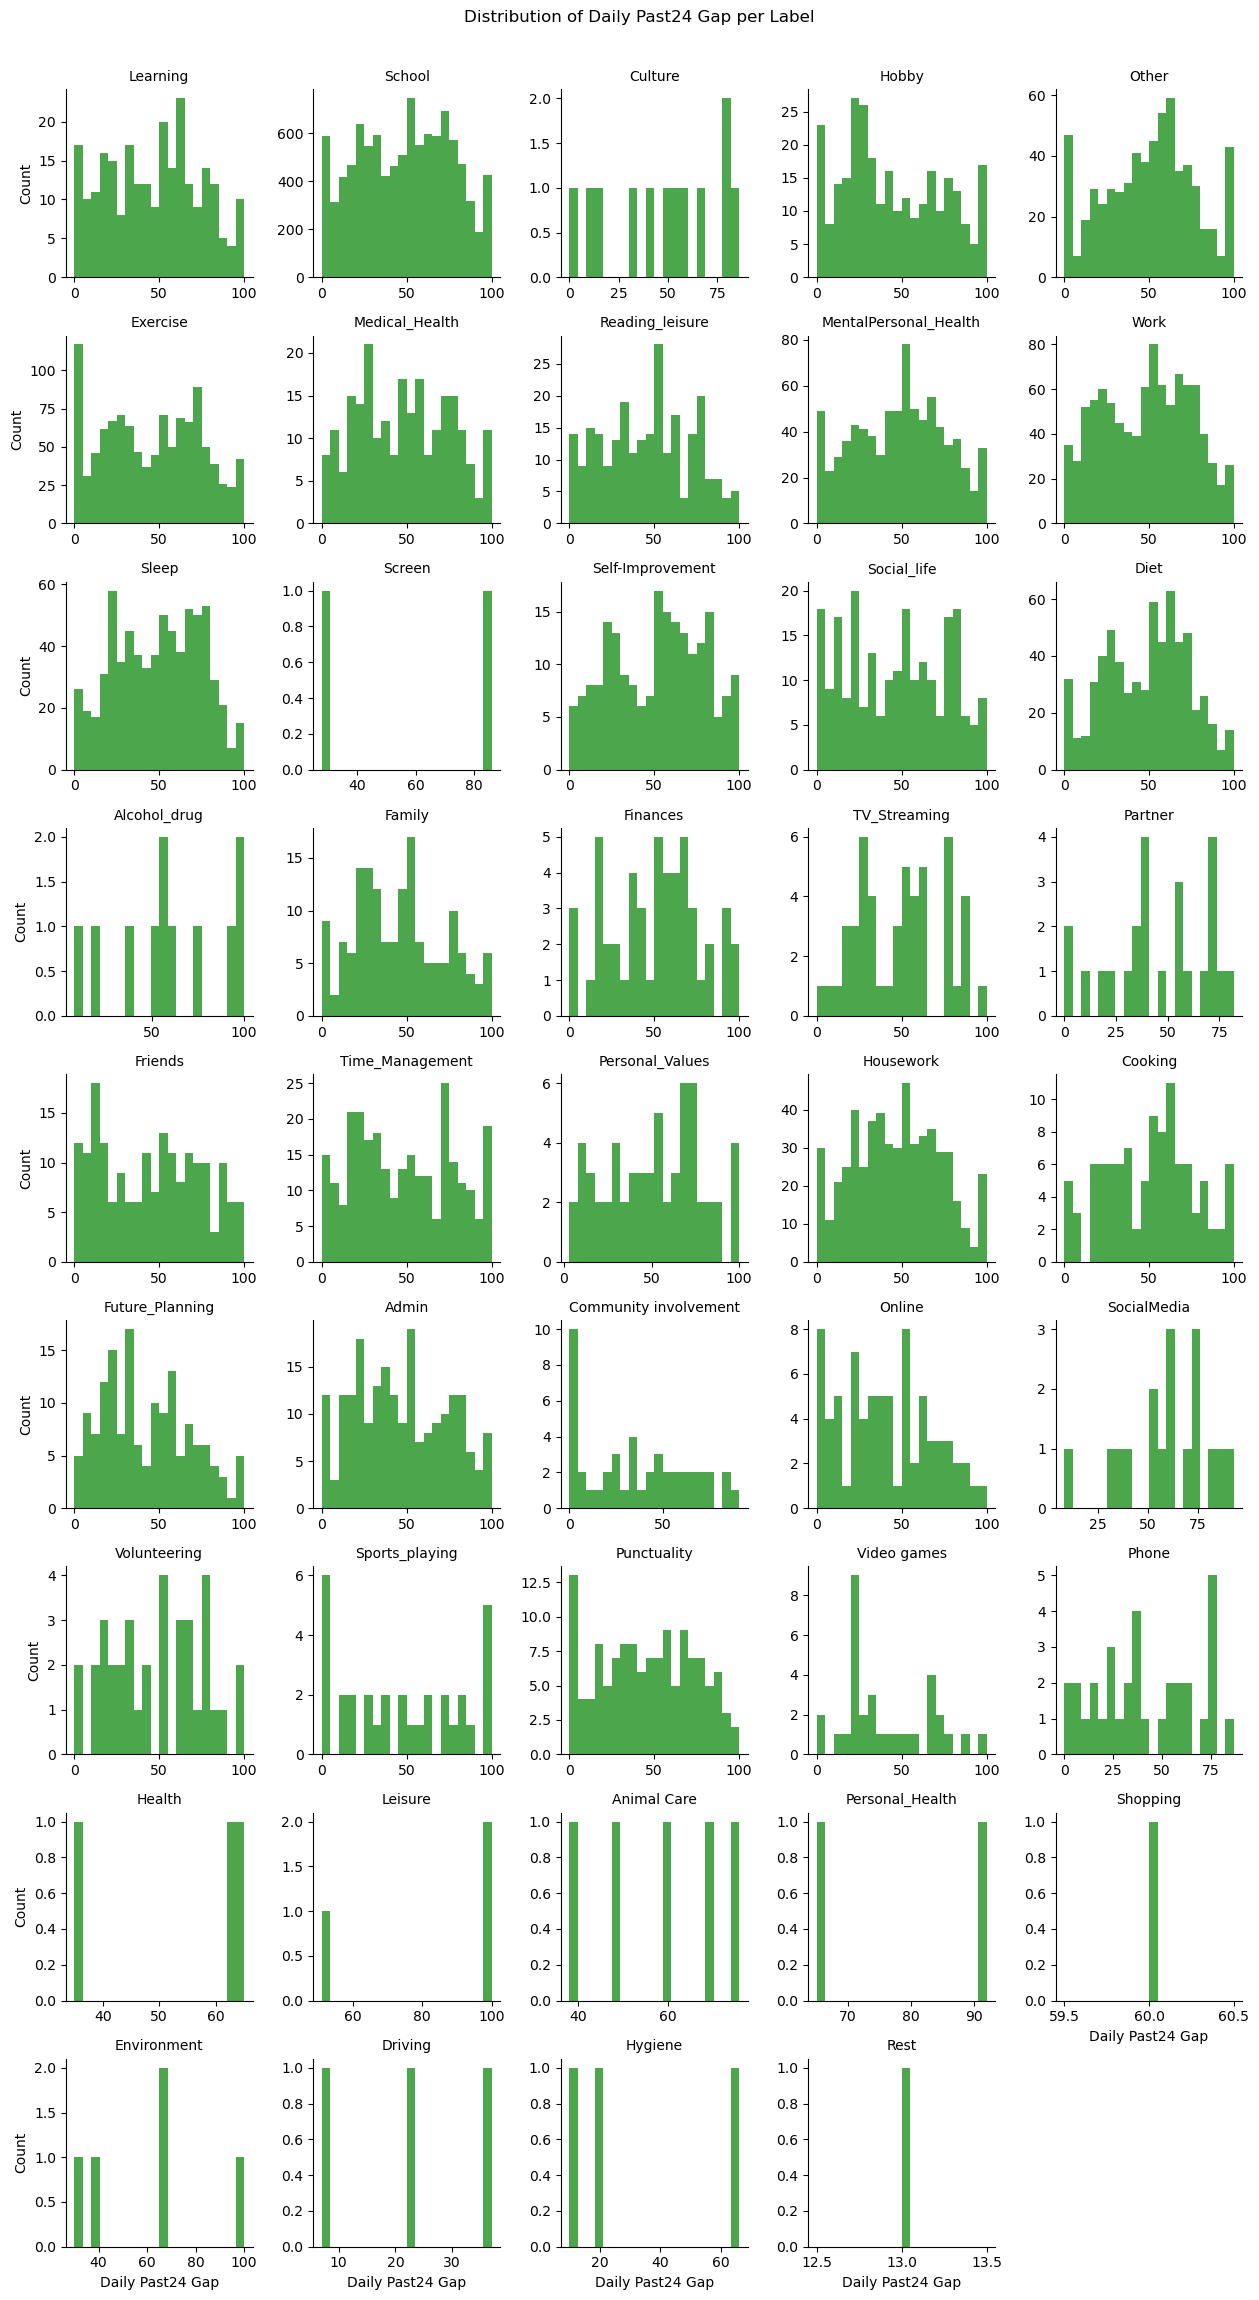

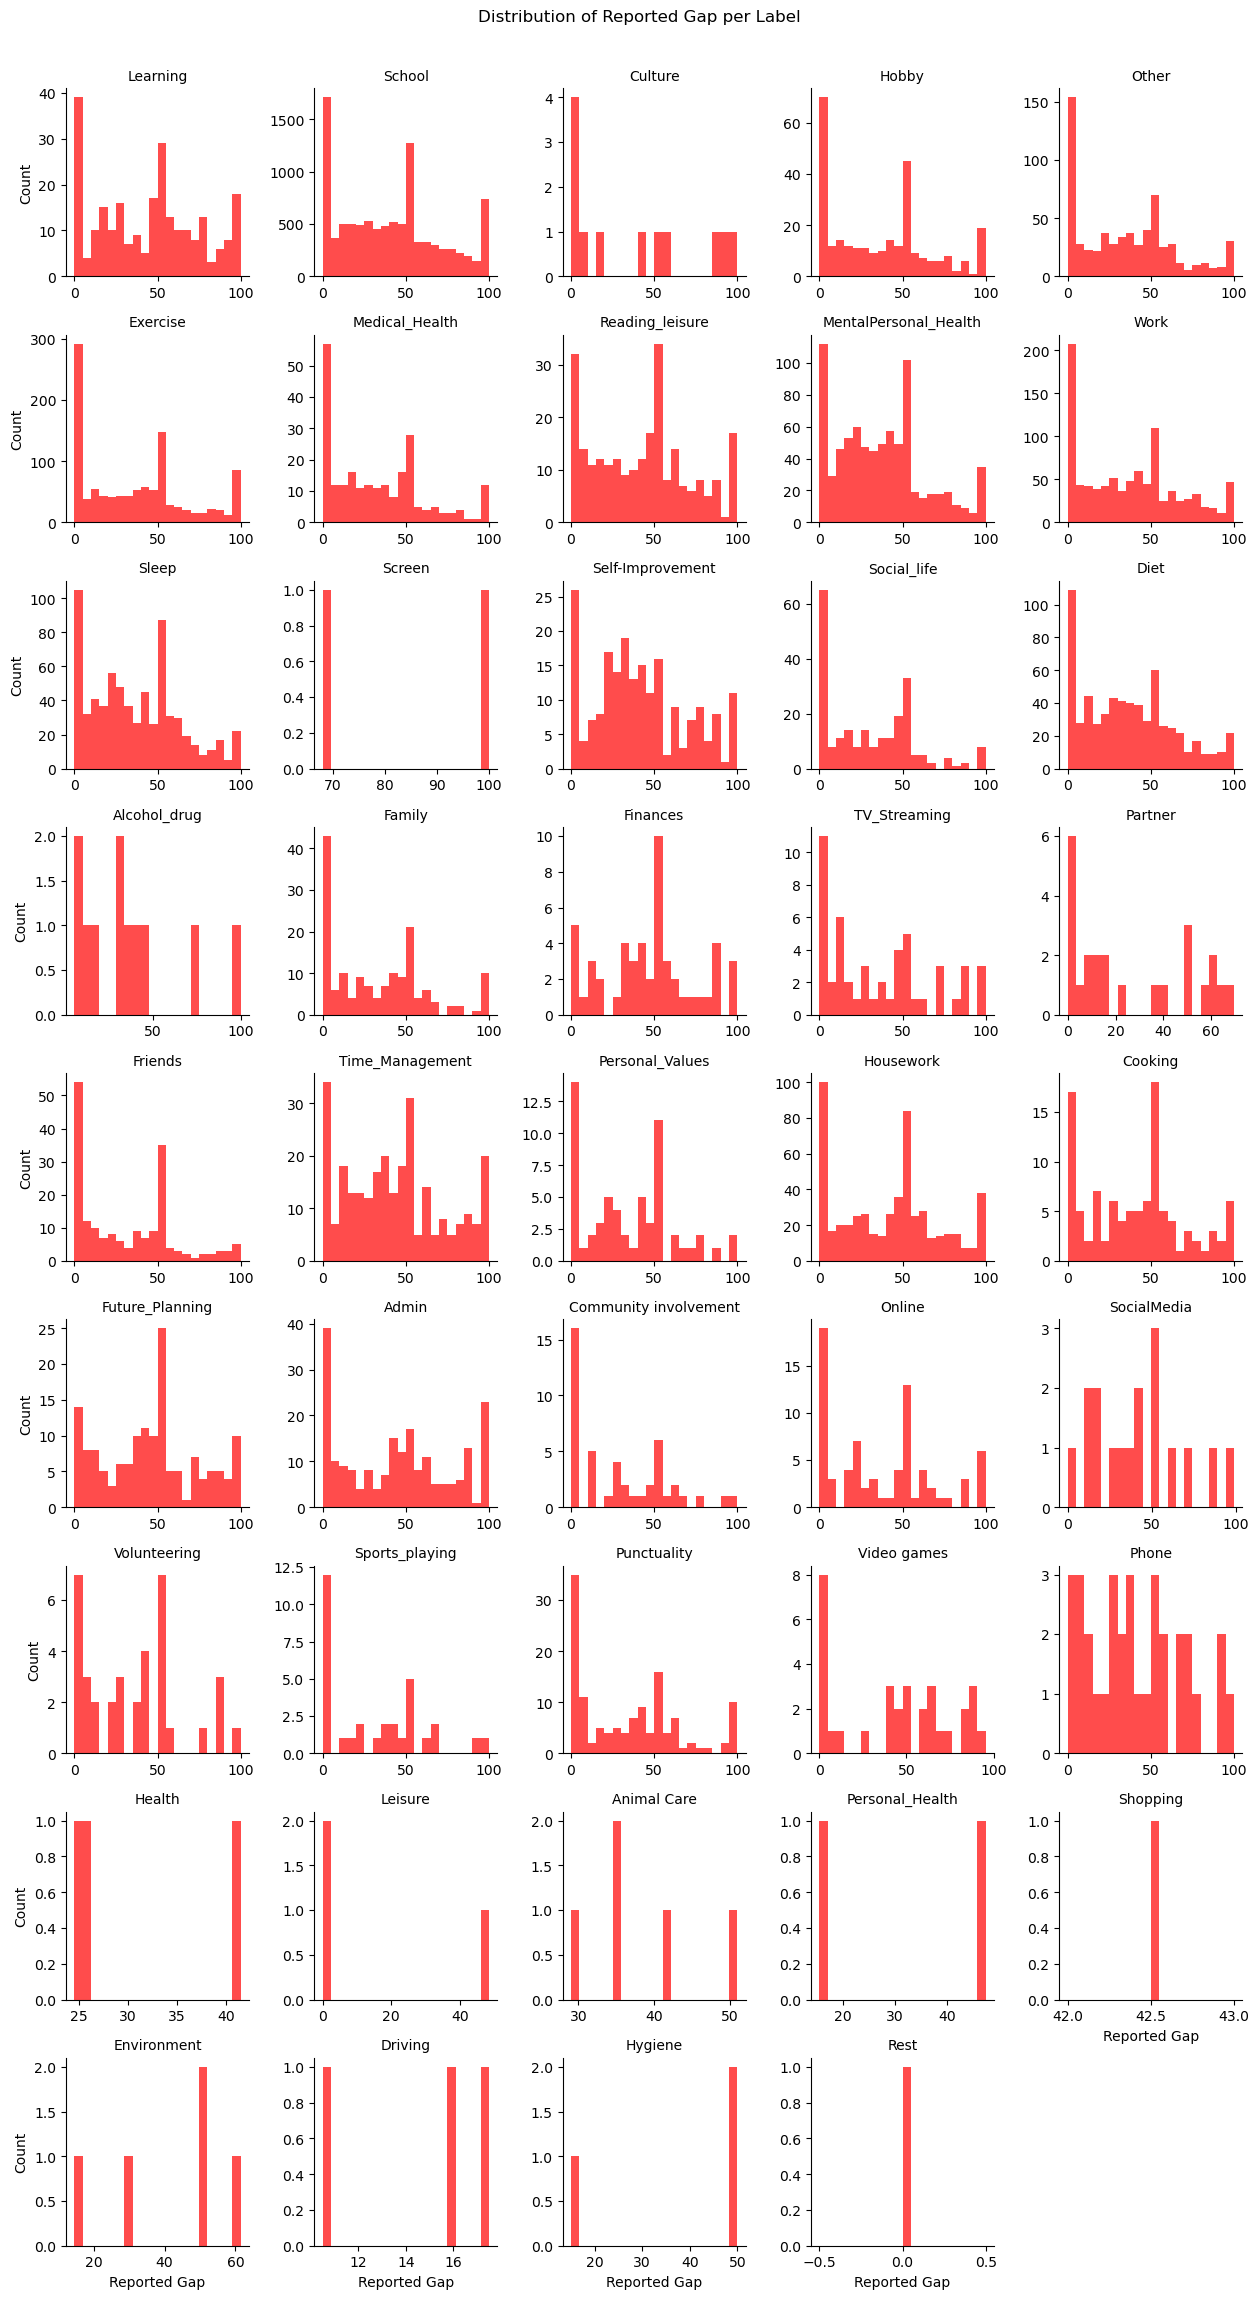

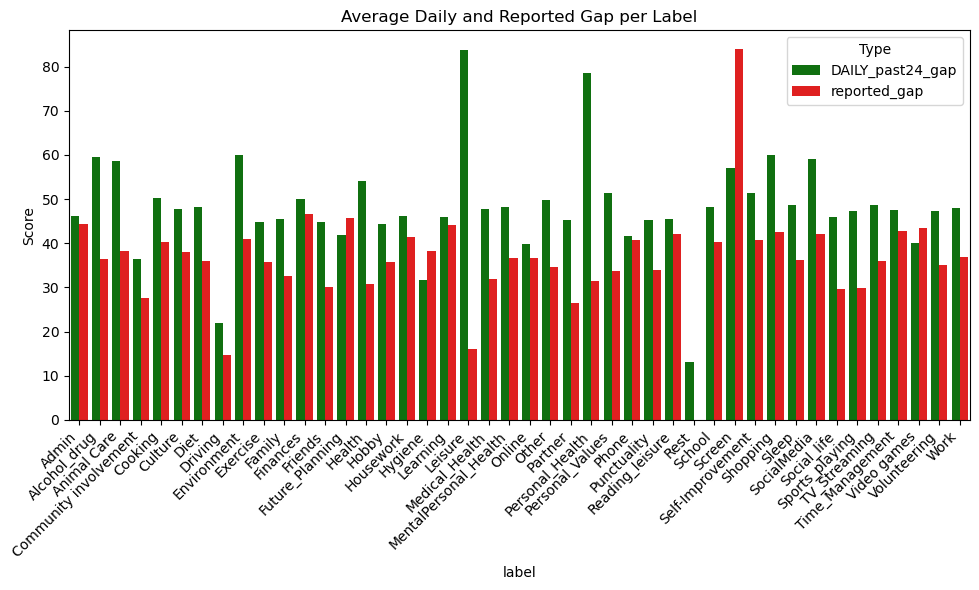

In [ ]:
df = gap_goal_type

# --- 1. Grid of histograms for POS ---
g_pos = sns.FacetGrid(df, col="label", col_wrap=5, sharex=False, sharey=False, height=2.5)
g_pos.map(plt.hist, "DAILY_past24_gap", bins=20, color="green", alpha=0.7)
g_pos.set_titles("{col_name}")
g_pos.set_axis_labels("Daily Past24 Gap", "Count")
g_pos.fig.suptitle("Distribution of Daily Past24 Gap per Label", y=1.02)

# --- 2. Grid of histograms for NEG ---
g_neg = sns.FacetGrid(df, col="label", col_wrap=5, sharex=False, sharey=False, height=2.5)
g_neg.map(plt.hist, "reported_gap", bins=20, color="red", alpha=0.7)
g_neg.set_titles("{col_name}")
g_neg.set_axis_labels("Reported Gap", "Count")
g_neg.fig.suptitle("Distribution of Reported Gap per Label", y=1.02)

# --- 3. Bar chart of average pos vs neg per label ---
avg_scores = df.groupby("label")[["DAILY_past24_gap", "reported_gap"]].mean().reset_index()
avg_scores = avg_scores.melt(id_vars="label", var_name="Type", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=avg_scores, x="label", y="Score", hue="Type",
            palette={"DAILY_past24_gap": "green", "reported_gap": "red"})
plt.xticks(rotation=45, ha="right")
plt.title("Average Daily and Reported Gap per Label")
plt.tight_layout()
plt.show()


___
___

In [297]:
cols = [
    "ParticipantIdentifier",
    "trial_date",
    "ResponseIdentifier",
    "Answers",
    "label"
]

lab_daily_goals_DF = pd.read_csv("./data/proc/daily_goals_labelled_long.csv")[cols]

In [298]:
lab_daily_goals_DF.head()
# pd.read_csv(labelled_daily_goals_long_path)

,ParticipantIdentifier,trial_date,ResponseIdentifier,Answers,label
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,DAILY_goal1_set,"Study history and psychology, practice the violin",Learning
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,DAILY_goal1_set,study history lectures,School
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,DAILY_goal1_set,Watch a historical movie,Culture
3,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-03,DAILY_goal1_set,review,School
4,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-04,DAILY_goal1_set,review,School


In [299]:
grouped = (
    lab_daily_goals_DF
    .groupby(["ParticipantIdentifier", "label"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

grouped.head()


,ParticipantIdentifier,label,count
1775,bf670311-c590-473a-98ab-d719ebf0f2ab,School,157
701,40538a74-9b24-4ef5-8995-dc341a005aac,Other,155
2182,f14a17bf-6d39-4cdd-b1b5-a9379db5aa4c,School,152
992,63f4637d-9f05-4561-8995-667470be3c7c,School,151
698,3e1d1276-0e73-4457-9911-f189b0ed0778,School,150


In [300]:
grouped_wide = grouped.pivot_table(
    index=['ParticipantIdentifier'],
    columns='label',
    values='count',
    aggfunc='first'
).reset_index()

grouped_wide.head()

label,ParticipantIdentifier,Admin,Alcohol_drug,Animal Care,Community involvement,Cooking,Culture,Diet,Driving,Environment,...,Sleep,SocialMedia,Social_life,Sports_playing,TV_Streaming,Time_Management,Travel,Video games,Volunteering,Work
0,0151d9f1-1644-4437-805e-02f5e244a690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
1,02f48bee-6e86-437c-9394-10ae57dadd14,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1.0,NaN,7.0
2,042d7595-3fdc-4cf9-b288-c4b7961916d8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
3,0501ba67-3406-4779-aff1-878a0e9f7885,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4,06af7782-cd70-4938-8e67-b6d98b34b665,1.0,NaN,NaN,NaN,3.0,NaN,11.0,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [301]:
goal_categories = [
 'Admin',
 'Alcohol_drug',
 'Animal Care',
 'Community involvement',
 'Cooking',
 'Culture',
 'Diet',
 'Driving',
 'Environment',
 'Exercise',
 'Family',
 'Finances',
 'Friends',
 'Future_Planning',
 'Health',
 'Hobby',
 'Housework',
 'Hygiene',
 'Learning',
 'Leisure',
 'Medical_Health',
 'MentalPersonal_Health',
 'Online',
 'Other',
 'Partner',
 'Personal_Health',
 'Personal_Values',
 'Phone',
 'Punctuality',
 'Reading_leisure',
 'Rest',
 'School',
 'Screen',
 'Self-Improvement',
 'Shopping',
 'Sleep',
 'SocialMedia',
 'Social_life',
 'Sports_playing',
 'TV_Streaming',
 'Time_Management',
 'Travel',
 'Video games',
 'Volunteering',
 'Work'
 ]

In [302]:
grouped_wide = grouped_wide.fillna(0) 

In [303]:
grouped_wide["#_goals"] = grouped_wide[goal_categories].sum(axis=1, skipna=True)

In [304]:
grouped_wide.head()

label,ParticipantIdentifier,Admin,Alcohol_drug,Animal Care,Community involvement,Cooking,Culture,Diet,Driving,Environment,...,SocialMedia,Social_life,Sports_playing,TV_Streaming,Time_Management,Travel,Video games,Volunteering,Work,#_goals
0,0151d9f1-1644-4437-805e-02f5e244a690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,170.0
1,02f48bee-6e86-437c-9394-10ae57dadd14,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,170.0
2,042d7595-3fdc-4cf9-b288-c4b7961916d8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,145.0
3,0501ba67-3406-4779-aff1-878a0e9f7885,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,158.0
4,06af7782-cd70-4938-8e67-b6d98b34b665,1.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0


In [305]:
grouped_wide = grouped_wide.loc[grouped_wide["#_goals"] >= 90]

In [306]:
len(grouped_wide)

139

In [307]:
grades_path = "./results/academic_results.csv"

cols = [
    "ParticipantIdentifier",
    "grade"
]

gradesDF = pd.read_csv(grades_path)[cols]
gradesDF.head()

,ParticipantIdentifier,grade
0,852c24f8-36d6-4bbd-b79f-7f6fe64d1275,74.566667
1,630ece82-994f-4aef-b2e3-46760583e453,82.666667
2,f55d6d94-8602-46cb-b3bd-53ea561eb296,66.750000
3,4e465685-8d64-4b22-8b6c-9409f9eb3c02,70.666667
4,63f4637d-9f05-4561-8995-667470be3c7c,77.200000


In [308]:
freq_x_grade = grouped_wide.merge(
    gradesDF,
    on="ParticipantIdentifier",
    how="inner")

In [309]:
freq_x_grade

,ParticipantIdentifier,Admin,Alcohol_drug,Animal Care,Community involvement,Cooking,Culture,Diet,Driving,Environment,...,Social_life,Sports_playing,TV_Streaming,Time_Management,Travel,Video games,Volunteering,Work,#_goals,grade
0,0151d9f1-1644-4437-805e-02f5e244a690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,170.0,92.800000
1,02f48bee-6e86-437c-9394-10ae57dadd14,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,170.0,64.888889
2,06af7782-cd70-4938-8e67-b6d98b34b665,1.0,0.0,0.0,0.0,3.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0,84.375000
3,075f7c4e-edea-4d64-8844-f046a1beb770,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,170.0,71.111111
4,077803ce-0421-40c5-846d-40f0a9ac6a83,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,170.0,74.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,f8f71506-9382-40c7-99db-5c170b2a9abb,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,8.0,0.0,1.0,0.0,5.0,170.0,74.913043
58,fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,87.500000
59,fc490430-6a41-4853-a2cf-ae0b15265cb6,3.0,0.0,0.0,3.0,0.0,0.0,15.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,0.0,0.0,10.0,170.0,65.375000
60,fee5cd07-329a-4f07-bb1a-913dfa09e3b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,170.0,75.611111


In [310]:
len(freq_x_grade)

62

In [311]:
selected_goal_categories = [
    "#_goals",
    "grade",
    "School",
    "Learning",
    "Time_Management",
    "Sleep",
    "Exercise",
    "MentalPersonal_Health",
    "Social_life",
    "Work",
    "Self-Improvement",
]

freq_x_grade_xx = freq_x_grade[selected_goal_categories]

In [312]:
freq_x_grade_xx

,#_goals,grade,School,Learning,Time_Management,Sleep,Exercise,MentalPersonal_Health,Social_life,Work,Self-Improvement
0,170.0,92.800000,127.0,4.0,0.0,0.0,1.0,4.0,0.0,7.0,0.0
1,170.0,64.888889,71.0,3.0,0.0,0.0,25.0,14.0,4.0,7.0,1.0
2,169.0,84.375000,98.0,2.0,0.0,7.0,1.0,0.0,0.0,1.0,0.0
3,170.0,71.111111,69.0,0.0,0.0,9.0,0.0,1.0,0.0,14.0,0.0
4,170.0,74.125000,97.0,0.0,2.0,0.0,3.0,2.0,2.0,10.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
57,170.0,74.913043,62.0,0.0,8.0,7.0,21.0,11.0,0.0,5.0,2.0
58,170.0,87.500000,117.0,5.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0
59,170.0,65.375000,71.0,2.0,4.0,3.0,2.0,3.0,2.0,10.0,1.0
60,170.0,75.611111,145.0,0.0,0.0,2.0,5.0,7.0,0.0,0.0,0.0


In [ ]:
na_summary = pd.DataFrame({
    "NaN_count": freq_x_grade_xx.isna().sum(),
    "NonNaN_count": freq_x_grade_xx.notna().sum(),
    "Total": len(freq_x_grade_xx)
})
print(na_summary)

                       NaN_count  NonNaN_count  Total
#_goals                        0            62     62
grade                          0            62     62
School                         0            62     62
Learning                      27            35     62
Time_Management               23            39     62
Sleep                         20            42     62
Exercise                      17            45     62
MentalPersonal_Health         14            48     62
Social_life                   27            35     62
Work                          11            51     62
Self-Improvement              27            35     62


In [ ]:
# formula = "grade ~ School + Learning + Time_Management + Sleep + Exercise + MentalPersonal_Health + Social_life + Work"

# model = smf.ols(formula=formula, data=freq_x_grade_xx.dropna()).fit()
# print(model.summary())

/var/folders/2j/ryb6v7ns2t9760z6yvvtp83m0000gn/T/ipykernel_33839/1816802006.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_x_grade_xx[f"{cat}_prop"] = freq_x_grade_xx[cat] / freq_x_grade_xx["#_goals"]
/var/folders/2j/ryb6v7ns2t9760z6yvvtp83m0000gn/T/ipykernel_33839/1816802006.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_x_grade_xx[f"{cat}_prop"] = freq_x_grade_xx[cat] / freq_x_grade_xx["#_goals"]
/var/folders/2j/ryb6v7ns2t9760z6yvvtp83m0000gn/T/ipykernel_33839/1816802006.py:12: Setti

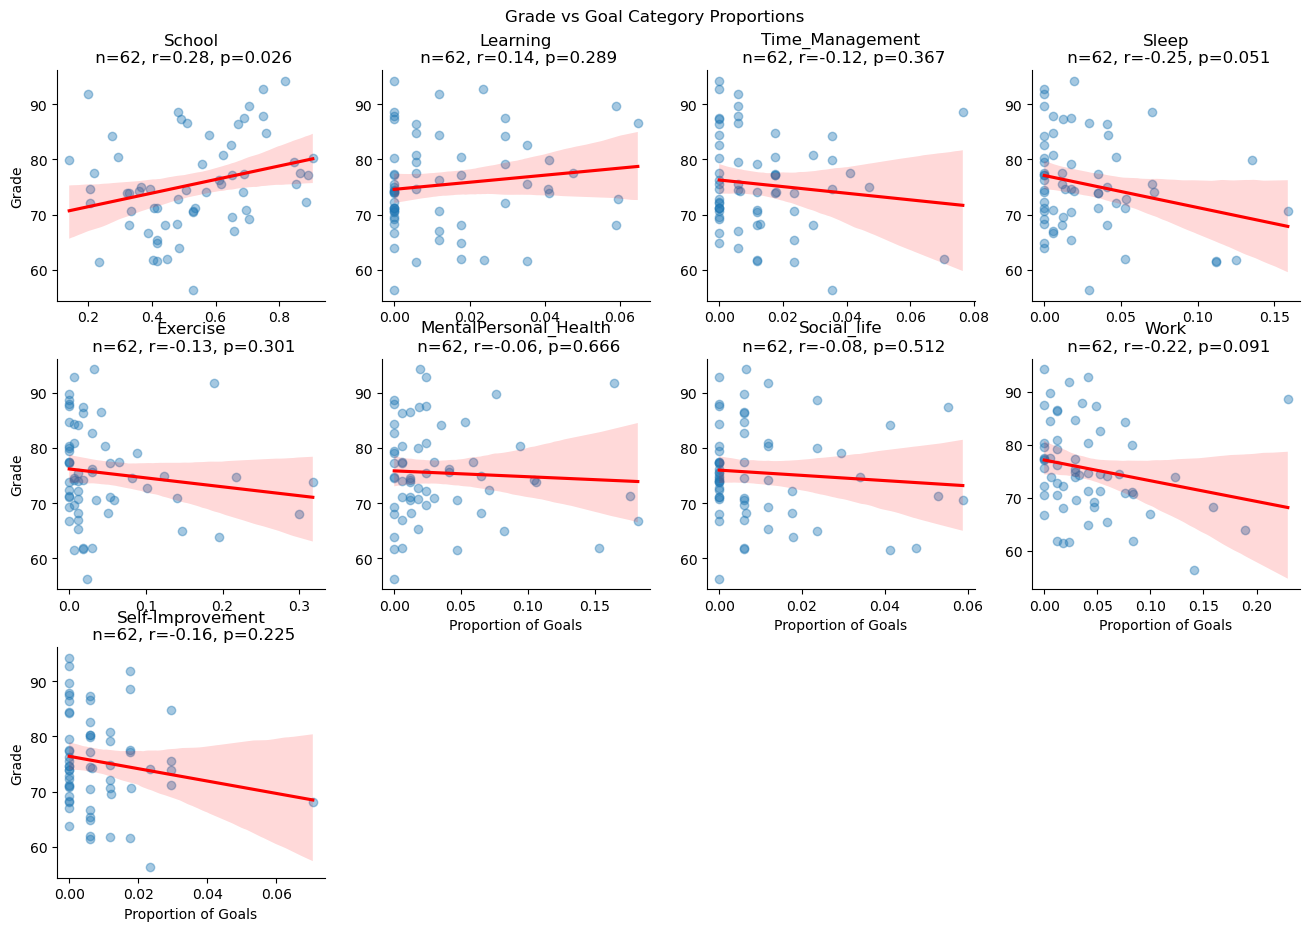

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

goal_categories = [
    "School", "Learning", "Time_Management", "Sleep", "Exercise",
    "MentalPersonal_Health", "Social_life", "Work", "Self-Improvement"
]

# proportions
for cat in goal_categories:
    freq_x_grade_xx[f"{cat}_prop"] = freq_x_grade_xx[cat] / freq_x_grade_xx["#_goals"]

# tidy long df
long_df = freq_x_grade_xx.melt(
    id_vars=["grade"],
    value_vars=[f"{cat}_prop" for cat in goal_categories],
    var_name="Category", value_name="Proportion"
)
long_df["Category"] = long_df["Category"].str.replace("_prop", "", regex=False)

# compute n, r, p for each category
stats_dict = {}
for cat in goal_categories:
    sub = long_df[long_df["Category"] == cat].dropna(subset=["Proportion", "grade"])
    n = len(sub)
    if n > 1:
        r, p = pearsonr(sub["Proportion"], sub["grade"])
        stats_dict[cat] = (n, r, p)
    else:
        stats_dict[cat] = (n, float("nan"), float("nan"))

# facet scatter+regression
g = sns.FacetGrid(long_df, col="Category", col_wrap=4, sharex=False, sharey=False, height=3, aspect=1.1)
g.map_dataframe(sns.regplot, x="Proportion", y="grade",
                scatter_kws={"alpha":0.4}, line_kws={"color":"red"})

# custom titles with n, r, p
def title_with_stats(cat):
    n, r, p = stats_dict.get(cat, (0, float("nan"), float("nan")))
    if n > 1:
        return f"{cat}\n n={n}, r={r:.2f}, p={p:.3f}"
    else:
        return f"{cat}\n n={n}, r=NA, p=NA"

for ax, cat in zip(g.axes.flatten(), g.col_names):
    ax.set_title(title_with_stats(cat))

g.set_axis_labels("Proportion of Goals", "Grade")
g.fig.suptitle("Grade vs Goal Category Proportions", y=1.03)
plt.show()
